In [1]:
import os, sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def collectSubjectData(topPath,dataPath,groups,subjects,colors):

    # set up variables
    data_columns = ['subjectID','classID','colors']
    data =  pd.DataFrame([],columns=data_columns)

    # populate structure
    data['subjectID'] = [ f for g in groups for f in subjects[g] ]
    data['classID'] = [ g for g in groups for f in range(len(subjects[g]))]
    data['colors'] = [ colors[c] for c in colors for f in subjects[c]]

    # output data structure for records and any further analyses
    if not os.path.exists(dataPath):
        os.mkdir(dataPath)

    data.to_csv(dataPath+'subjects.csv',index=False)

    return data

def collectData(datatype,datatype_tags,tags,filename,subjects_data,colors,outPath):

    import requests
    import pandas as pd

    # grab path and data objects
    objects = requests.get('https://brainlife.io/api/warehouse/secondary/list/%s'%os.environ['PROJECT_ID']).json()
    
    # subjects and paths
    subjects = []
    paths = []
    
    # set up output
    data = pd.DataFrame()

    # loop through objects
    for obj in objects:
        if obj['datatype']['name'] == datatype:
            if datatype_tags in obj['output']['datatype_tags']:
                if tags in obj['output']['tags']:
                    subjects = np.append(subjects,obj['output']['meta']['subject'])
                    paths = np.append(paths,"input/"+obj["path"]+"/"+filename)
    
    # sort paths by subject order
    paths = [x for _,x in sorted(zip(subjects,paths))]

    for i in paths:
        tmpdata = pd.read_csv(i)
        if tmpdata.subjectID.dtypes != 'object':
            tmpdata['subjectID'] = [ str(int(np.float(f))) for f in tmpdata.subjectID ]
        if 'classID' in tmpdata.keys():
            tmpdata = pd.merge(tmpdata,subjects_data,on=['subjectID','classID'])
        else:
            tmpdata = pd.merge(tmpdata,subjects_data,on='subjectID')
        data = data.append(tmpdata,ignore_index=True)
            
    # replace empty spaces with nans
    data = data.replace(r'^\s+$', np.nan, regex=True)

    # output data structure for records and any further analyses
    # subjects.csv
    data.to_csv(outPath,index=False)

    return data


In [3]:
# set up empty dictionaries
subjects = {}
colors = {}
groups = {}

# populate dictionaries with groups
groups['concussed'] = []
groups['controls'] = []

# populate subjects dictionaries with appropriate subject indicies
subjects['concussed'] = ['3_041','3_042','3_043','3_044','3_045','3_047','3_050','4_054','4_065']
subjects['controls'] = ['3_038','3_046','4_051','4_053','4_055','4_056','4_057','4_059','4_060','4_061','4_062','4_063','4_064','4_066','4_067','4_068','4_069','4_072','4_073','4_074']

# set colors dictionary
colors['concussed'] = 'red'
colors['controls'] = 'blue'

# set toppath and save path (datapath)
topPath = './'
dataPath = topPath

# create subjects dataframe
subjects_data = collectSubjectData(topPath,dataPath,groups,subjects,colors)

In [39]:
str(subjects_data['subjectID'].tolist()).replace('[','').replace(']','').replace(',','').replace("'",'').replace(' ','|')

'3_041|3_042|3_043|3_044|3_045|3_047|3_050|4_054|4_065|3_038|3_046|4_051|4_053|4_055|4_056|4_057|4_059|4_060|4_061|4_062|4_063|4_064|4_066|4_067|4_068|4_069|4_072|4_073|4_074'

In [4]:
if os.path.isfile('./data/cortical_glasser.csv'):
    cortical_data = pd.read_csv('./data/cortical_glasser.csv')
else:
    cortical_data = collectData('neuro/parc-stats','cortex_mapping_stats','bl_paper','parc_MEAN.csv',subjects_data,colors,'./data/cortical_glasser.csv')

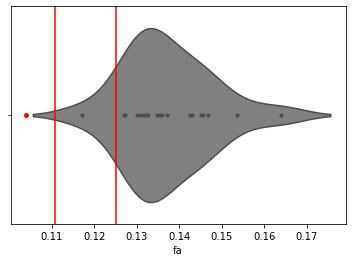

In [23]:
sns.violinplot(x='fa',data=cortical_data.loc[cortical_data['structureID'] == 'L_STSda_ROI'].loc[cortical_data['classID'] == 'controls'],color='grey',scale='count',inner='points')
sns.swarmplot(x='fa',data=cortical_data.loc[cortical_data['structureID'] == 'L_STSda_ROI'].loc[cortical_data['subjectID'] == '3_050'],color='red',size=5)
plt.axvline(np.percentile(cortical_data.loc[cortical_data['structureID'] == 'L_STSda_ROI'].loc[cortical_data['classID'] == 'concussed']['fa'],50),color='red')
plt.axvline(np.percentile(cortical_data.loc[cortical_data['structureID'] == 'L_STSda_ROI'].loc[cortical_data['classID'] == 'concussed']['fa'],10),color='red')
plt.savefig('./images/cortex_mapped_fa_l_sts_da_concussion_example.png')
plt.savefig('./images/cortex_mapped_fa_l_sts_da_concussion_example.eps')

In [9]:
np.percentile(cortical_data.loc[cortical_data['structureID'] == 'L_STSda_ROI'].loc[cortical_data['classID'] == 'concussed']['fa'],10)

0.11066214